In [1]:
from functional import *
from transformer_core import encoder
plt.rc('figure',titleweight='bold',titlesize='large',figsize=(15,6))
plt.rc('axes',titleweight='bold',titlesize='large',labelweight='bold',labelsize='large',grid=True)

2024-09-26 15:19:53.192712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 15:19:53.267396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 15:19:53.287587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 15:19:53.397496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 15:19:54.824215: W tensorflow/compiler/tf2

In [2]:
class timeseries_transformer(funtional):
    def __init__(self,num_heads=8,embed_dim=512,ff_dim=64):
        super().__init__()
        self.num_heads=num_heads
        self.embed_dim=embed_dim
        self.ff_dim=ff_dim
    def positional_encoding(self,n=10000):
        p=np.zeros((self.seq_length,self.embed_dim))
        for k in range(self.seq_length):
            for i in np.arange(self.embed_dim//2):
                denominator=np.power(n, 2*i/self.embed_dim)
                p[k, 2*i]=np.sin(k/denominator)
                p[k, 2*i+1]=np.cos(k/denominator)
        return p
    def transformer_model(self):
        inputs = tf.keras.layers.Input((self.seq_length,1))
        pos_enc = self.positional_encoding()
        data=inputs + pos_enc

        encoder_block=encoder(self.embed_dim,self.num_heads,self.ff_dim)
        data=encoder_block(data)
        data=tf.keras.layers.Dense(500, activation="leaky_relu")(data)
        data=tf.keras.layers.Dense(200, activation="leaky_relu")(data)
        data=tf.keras.layers.Dense(100, activation="leaky_relu")(data)
        data=tf.keras.layers.Dense(50, activation="leaky_relu")(data)
        data=tf.keras.layers.Dense(20, activation="leaky_relu")(data)
        data=tf.keras.layers.Flatten()(data)
        outputs = tf.keras.layers.Dense(1)(data)

        model=tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    
    def build(self,epochs=10,optimizer='adam',loss='mae',batch_size=32): 
        self.model=self.transformer_model()
        self.model.compile(optimizer=optimizer,loss=loss)
        best_lost=tf.keras.callbacks.ModelCheckpoint(os.path.join(Path().cwd(),f'models/transformer_{self.price_type}_{self.symbol}_{self.timeframe}.keras'),monitor='val_loss',mode='min',save_best_only=True)
        self.history=self.model.fit(self.x_train,self.y_train,epochs=epochs,batch_size=batch_size,callbacks=[best_lost],validation_data=(self.x_test,self.y_test))
        self.pred=self.model.predict(self.x_test)

In [3]:
num_heads=8
embed_dim=256
ff_dim=64
model=timeseries_transformer(num_heads,embed_dim,ff_dim)

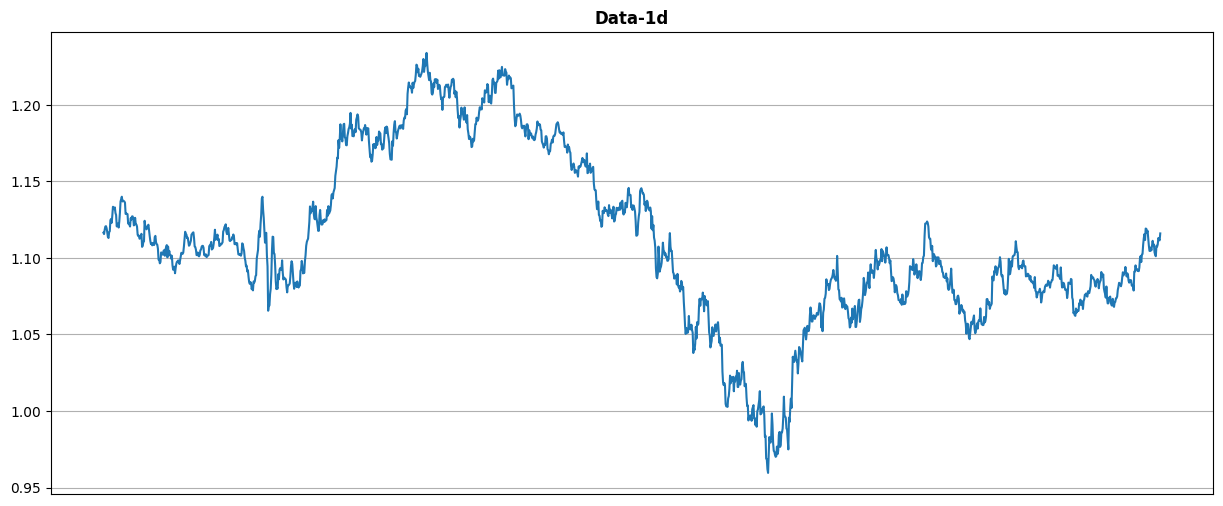

In [4]:
model.plot_data()

In [5]:
model.build(epochs=100)

Epoch 1/100


2024-09-26 15:19:57.902206: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.5325 - val_loss: 0.1714
Epoch 2/100
 5/37 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1108

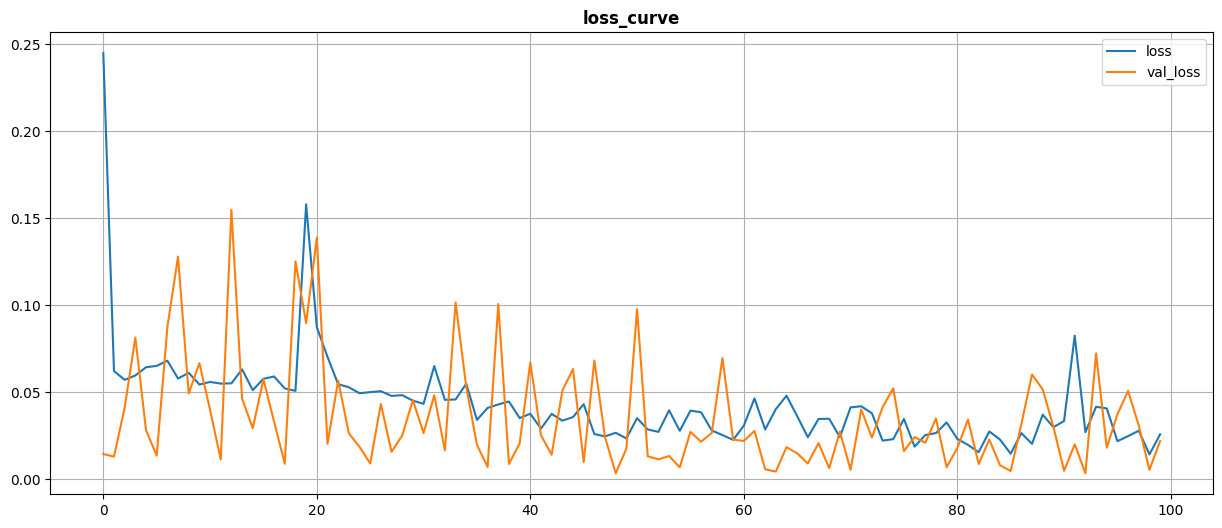

In [6]:
model.plot_history()